In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import scipy
import numpy as np
import rasterio as rio
from rasterstats import zonal_stats
from glob import glob
import geopandas as gpd
import censusdata

from src.utils import *
from src.params import *
tqdm.pandas()

import numpy as np
from pysal.explore import esda
from pysal.lib import weights
np.random.seed(42)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load Model

In [3]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v7.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'slope', 'age_median', 'income_median'], is_balanced=True, hierarchy_type='county')

balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# Inference

In [4]:
# Basin parameters
basin_params = pd.read_csv('../tmp/basin_params_with_attributes_v2.csv')

attributes = [
    'ppt_similarity_c','ppt_income_mu',
    'hydr_similarity_c','hydr_age_mu','hydr_income_mu',
    'slope_similarity_c',
    'hse_similarity_c','hse_age_mu','hse_income_mu'
]
attr_params = dict()

for attribute in attributes:
    attr_params[attribute] = basin_params[attribute].mean()
    
attr_params

{'ppt_similarity_c': -0.03874433713082499,
 'ppt_income_mu': 4.438532715272993,
 'hydr_similarity_c': 0.010756579180810471,
 'hydr_age_mu': 2.7917499812014217,
 'hydr_income_mu': 1.4873088793399418,
 'slope_similarity_c': 4.997885023098349,
 'hse_similarity_c': 0.07081607127727259,
 'hse_age_mu': 2.420979273469456,
 'hse_income_mu': 1.3052518581243935}

In [5]:
# Get inference data for each state
def get_inference_data(indep_srcs, state_id):
    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster mean value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            
            # convert to slope
            if indep_var == 'slope':
                array = np.where(array == 32767, np.nan, array)
                res = src.res[0]  # pixel resolution in degrees
                elevation_deg = np.degrees(np.arctan(array / np.sqrt(res**2 + res**2)))
                slope_x, slope_y = np.gradient(elevation_deg, res, res)
                array = np.degrees(np.arctan(np.sqrt(slope_x**2 + slope_y**2)))

            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='median'))
        
        var_name = f'{indep_var}_median'
        state_bdry[var_name] = zones['median']

    # Get housing value
    acs_dict_list = [
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B25077_001E','col_name': 'hse_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B06002_001E','col_name': 'age_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B07411_001E','col_name': 'income_median'}
    ]    

    for acs_dict in acs_dict_list:
        acs = (censusdata.download(
            acs_dict['type'],
            acs_dict['year'], 
            censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
        ).reset_index().rename(columns={acs_dict['code']: acs_dict['col_name']}))

        for i, row in acs.iterrows():
            county = (str(row['index'])
                        .split(',')[0]
                        .split('County')[0]
                        .strip())

            acs.loc[i, 'County'] = county
        
        for i, row in state_bdry.iterrows():
            try:
                mean = acs[acs['County'] == row['NAME']][acs_dict['col_name']].item()
                state_bdry.loc[i, acs_dict['col_name']] = mean
            except:
                state_bdry.loc[i, acs_dict['col_name']] = 0

    return state_bdry

# Compute probability of failure 
def compute_risk_probability(gdf, attr_params, basin_params, sampling_sz=100, runs=5):
    """Compute risk probability (and its uncertainty) over (sampling_sz * n) runs given both attributes and basin-level parameters"""
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        x_params = {
            'ppt': pm.Normal.dist(mu=attr_params['ppt_similarity_c'] + attr_params['ppt_income_mu'] * gdf['income_median'], sigma=pm.HalfNormal.dist(sigma=10)),
            'hydr': pm.Normal.dist(mu=attr_params['hydr_similarity_c'] + attr_params['hydr_age_mu'] * gdf['age_median'] + attr_params['hydr_income_mu'] * gdf['income_median'], sigma=pm.HalfNormal.dist(sigma=10)),
            'hse': pm.Normal.dist(mu=attr_params['hse_similarity_c'] + attr_params['hse_age_mu'] * gdf['age_median'] + attr_params['hse_income_mu'] * gdf['income_median'], sigma=pm.HalfNormal.dist(sigma=10)),
            'slope': pm.Exponential.dist(lam=abs(attr_params['slope_similarity_c']))
        }
        failure_theta = pm.math.sigmoid(
            basin_params['c'].mean()
            + pm.draw(x_params['ppt'], draws=sampling_sz).mean() * row['ppt_median']
            + pm.draw(x_params['hydr'], draws=sampling_sz).mean() * row['soil_median']
            + pm.draw(x_params['hse'], draws=sampling_sz).mean() * row['hse_median']
            + pm.draw(x_params['slope'], draws=sampling_sz).mean() * row['slope_median']
        )
        
        risks = []
        failures = pm.Bernoulli.dist(failure_theta)
        for j in range(runs):
            risk = pm.draw(failures, draws=sampling_sz)
            risks.append(risk.mean())
        
        risk_mean = np.array(risks).mean()
        risk_std = np.array(risks).std()
        gdf.loc[i, 'risk_mean'] = risk_mean
        gdf.loc[i, 'risk_std'] = risk_std
    
    return gdf

## Southeast
Subset to GA, FL, AL, TN, SC, NC, KY, VA, WV, AR, LA, MS

In [6]:
try:
    del all_gdf
except:
    pass

soil_files = glob('../../Data/soil/mosaic/*.tif')
southeast_states = ['GA', 'FL', 'AL', 'TN', 'SC', 'NC', 'KY', 'VA', 'WV', 'AR', 'LA', 'MS']
southeast_ids = [state_codes[state] for state in southeast_states]

for soil_file in soil_files:
    state_abbr = soil_file.split('/')[-1].split('.tif')[0]
    
    if state_abbr in southeast_states:
        print(f'Processing {state_abbr}')
        state_id = state_codes[state_abbr]
        indep_srcs = {
            'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
            'ppt': '../../Data/precipitation/annual_max_2021.tif',
            'soil': soil_file,
            'slope': '../../Data/dem/hyd_na_dem_15s.tif',
        }
        gdf = get_inference_data(indep_srcs, state_id=state_id)
        for var in ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'age_median', 'income_median']:
            gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
        gdf.reset_index(drop=True, inplace=True)
        gdf.fillna(0., inplace=True)
        gdf = compute_risk_probability(gdf, attr_params, basin_params, sampling_sz=100, runs=5)
        
        try:
            all_gdf = all_gdf.append(gdf)
        except:
            all_gdf = gdf

Processing GA


100%|██████████| 159/159 [00:35<00:00,  4.46it/s]


Processing SC


100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


Processing MS


100%|██████████| 82/82 [00:19<00:00,  4.21it/s]


Processing LA


100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


Processing AR


100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


Processing VA


100%|██████████| 133/133 [00:31<00:00,  4.19it/s]


Processing TN


100%|██████████| 95/95 [00:25<00:00,  3.73it/s]


Processing AL


100%|██████████| 67/67 [00:16<00:00,  4.01it/s]


Processing NC


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Processing WV


100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Processing FL


100%|██████████| 67/67 [00:17<00:00,  3.94it/s]


Processing KY


100%|██████████| 120/120 [00:30<00:00,  3.96it/s]


42.50160909676035
11.786697077125222


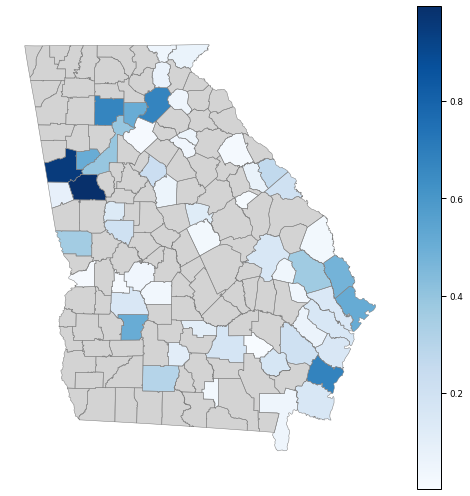

In [9]:
# Plot failing system percentage on failure risk > 0.5
df = pd.read_csv('../data/hierarchical_septics_v7.csv')

# encode categorical sewage system
enc, _ = pd.factorize(df['sewageSystem'])
df['sewageSystem_enc'] = enc
df.loc[df['sewageSystem_enc'] == 1, 'sewageSystem_enc'] = 'Failing' # need repair
df.loc[(df['sewageSystem_enc'] == 0) | (df['sewageSystem_enc'] == 2), 'sewageSystem_enc'] = 'Non-Failing' # new + addition

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))
gdf.set_crs('EPSG:4326', inplace=True)
ga_gdf = all_gdf[all_gdf['STATEFP'] == '13']

# Compute percentage
risk_prob = 0.5
failing_gdf = gdf[gdf['sewageSystem_enc'] == 'Failing']
combined_failing_df = failing_gdf.sjoin(ga_gdf, how='left')
combined_df = gdf.sjoin(ga_gdf, how='left')
failing_size = combined_failing_df.groupby('NAME').size()
system_size = combined_df.groupby('NAME').size()
failing_perc = (failing_size / sum(failing_size) * 100).reset_index()
failing_all_perc = (failing_size / sum(system_size) * 100).reset_index()
failing_perc = failing_perc.rename(columns={0: 'failing_percentage'})
failing_all_perc = failing_all_perc.rename(columns={0: 'failing_all_percentage'})
state_bdry = ga_gdf.merge(failing_perc, on='NAME')
state_bdry = state_bdry.merge(failing_all_perc, on='NAME')
state_bdry.loc[state_bdry['risk_mean'] < risk_prob, 'failing_percentage'] = np.nan
state_bdry.loc[state_bdry['risk_mean'] < risk_prob, 'failing_all_percentage'] = np.nan
print(state_bdry['failing_percentage'].sum()) # 45.9%
print(state_bdry['failing_all_percentage'].sum()) # 12.7%

# plotting
f, ax = plt.subplots(figsize=(7,7))
state_bdry.boundary.plot(edgecolor='grey', linewidth=0.5, ax=ax)
state_bdry.plot(column='failing_all_percentage', ax=ax, cmap='Blues', legend=True, missing_kwds= dict(color = 'lightgrey') )
ax.axis('off')
f.tight_layout()
f.savefig(f'../docs/ga_failing_syst_dist_{int(risk_prob * 100)}.pdf', dpi=300, bbox_inches='tight');

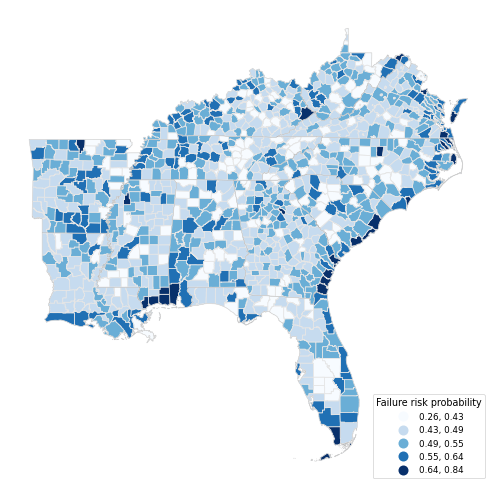

In [7]:
# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

southeast_gdf = all_gdf[all_gdf['STATEFP'].isin(southeast_ids)]
southeast_gdf.plot(
    column='risk_mean', 
    edgecolor='0.9',
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
# f.savefig('../docs/southeast_risk_map.pdf', dpi=300, bbox_inches='tight')

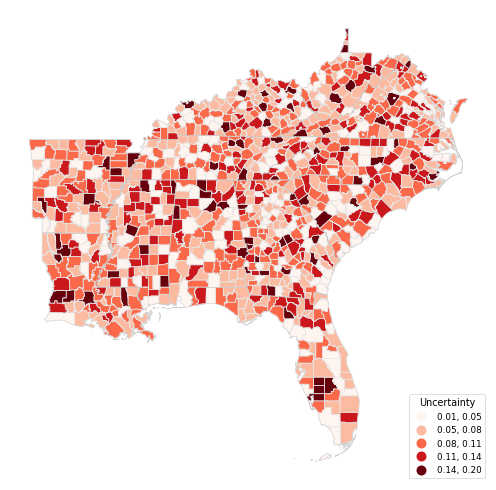

In [9]:
# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

southeast_gdf = all_gdf[all_gdf['STATEFP'].isin(southeast_ids)]
southeast_gdf['risk_std_norm'] = southeast_gdf['risk_std'] / southeast_gdf['risk_mean']
southeast_gdf.plot(
    column='risk_std_norm', 
    edgecolor='0.9',
    cmap='Reds', 
    scheme='natural_breaks',
    ax=ax,
    legend=True, legend_kwds={'title': 'Uncertainty', 'loc': 'lower right'})

bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()
# f.savefig('../docs/southeast_risk_map_std.pdf', dpi=300, bbox_inches='tight')

## Cluster Analysis

In [10]:
def generate_local_cluster(cluster_df, var, p_val = 0.05):
    w = weights.Queen.from_dataframe(cluster_df)
    go_i_star = esda.getisord.G_Local(cluster_df[var] + abs(cluster_df[var].min()), w, transform='r', star=True) #value shifted to floor 0 stability
    cluster_df[f'{var}_cluster_z'] = go_i_star.Zs

    sig = go_i_star.p_sim < p_val

    return cluster_df, sig

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Sha

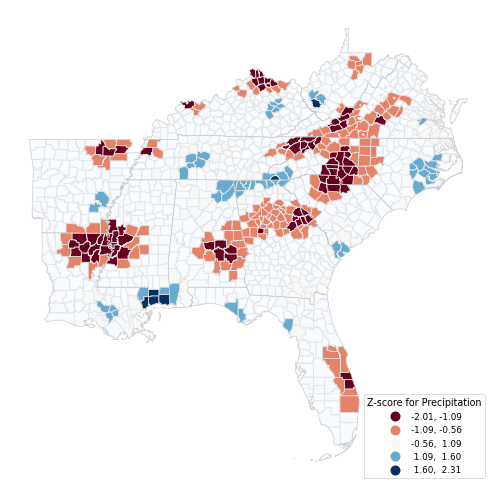

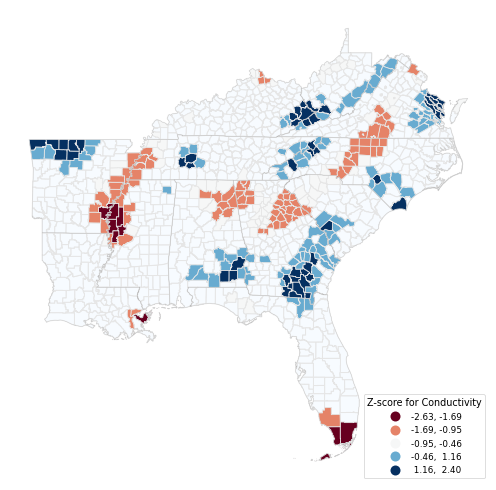

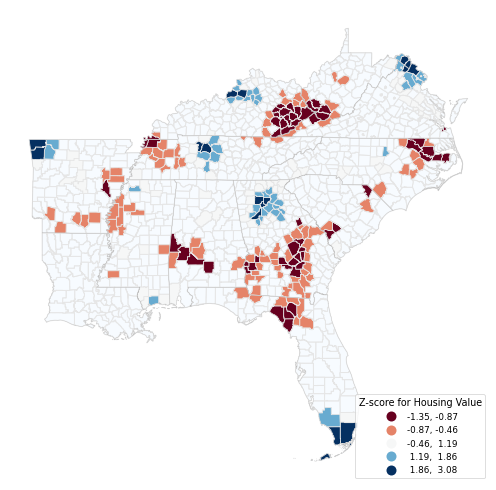

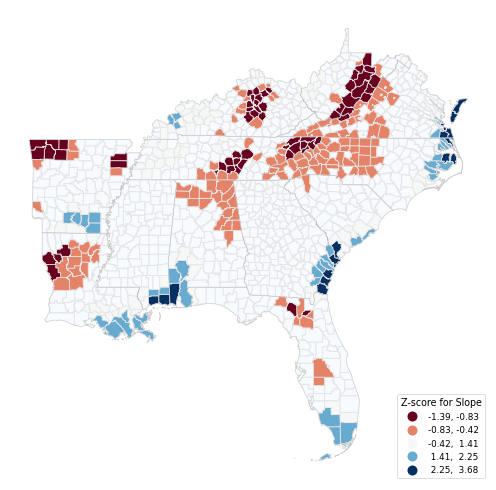

In [11]:
# All variables
southeast_gdf.reset_index(drop=True, inplace=True)
cluster_gdf = southeast_gdf

titles = ['Precipitation', 'Conductivity', 'Housing Value', 'Slope']
for i, var in enumerate(['ppt_median', 'soil_median', 'hse_median', 'slope_median']):
    cluster_gdf, sig = generate_local_cluster(cluster_gdf, var=var)

    # Plotting
    f, ax = plt.subplots(figsize=(7,7))

    # Plot non-significant clusters
    ns = cluster_gdf.loc[sig == False, 'geometry']
    ns.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # Plot clusters
    cluster_gdf[sig].plot(
        column=f'{var}_cluster_z', 
        scheme='natural_breaks', 
        ax=ax, cmap='RdBu', 
        legend=True,
        edgecolor='0.9',
        legend_kwds={'title': f'Z-score for {titles[i]}', 'loc': 'lower right'}
    )
    bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
        edgecolor='grey',
        linewidth=0.1,
        ax=ax
    )

    ax.axis('off')
    f.tight_layout()
    # f.savefig(f'../docs/cluster_{var}.pdf', dpi=300, bbox_inches='tight');

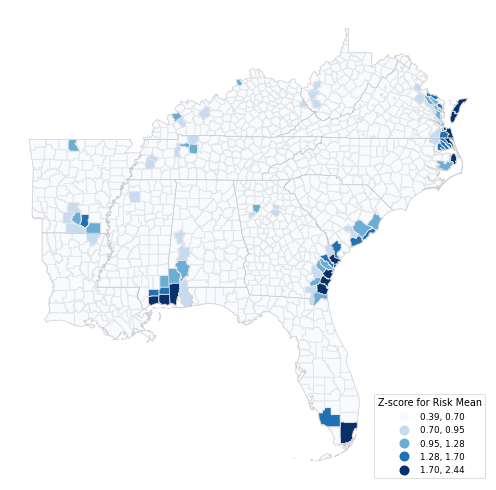

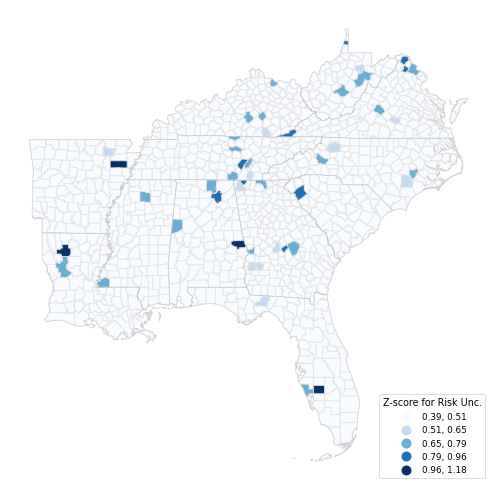

In [16]:
# Risk estimates
southeast_gdf.reset_index(drop=True, inplace=True)
cluster_gdf = southeast_gdf

titles = ['Risk Mean', 'Risk Unc.']
for i, var in enumerate(['risk_mean', 'risk_std_norm']):
    cluster_gdf, sig = generate_local_cluster(cluster_gdf, var=var)
    

    # Plotting
    f, ax = plt.subplots(figsize=(7,7))

    # Plot non-significant clusters
    ns = cluster_gdf.loc[sig == False, 'geometry']
    ns.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # low cluster
    lc = cluster_gdf[cluster_gdf[f'{var}_cluster_z'] <= 0]['geometry']
    lc.plot(ax=ax, color='#f7fbff', edgecolor='0.9', linewidth=1)

    # Plot clusters
    cluster_gdf[sig][cluster_gdf[f'{var}_cluster_z'] > 0].plot(
        column=f'{var}_cluster_z', 
        scheme='natural_breaks', 
        ax=ax, cmap='Blues', 
        legend=True,
        edgecolor='0.9',
        legend_kwds={'title': f'Z-score for {titles[i]}', 'loc': 'lower right'}
    )
    bdry[bdry['STATEFP'].isin(southeast_ids)].dissolve(by='STATEFP').boundary.plot(
        edgecolor='grey',
        linewidth=0.1,
        ax=ax
    )

    ax.axis('off')
    f.tight_layout()
    f.savefig(f'../docs/cluster_{var}.pdf', dpi=300, bbox_inches='tight');

### Correlation with uncertainty

In [13]:
def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}\np-val = {p:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

With uncertainty

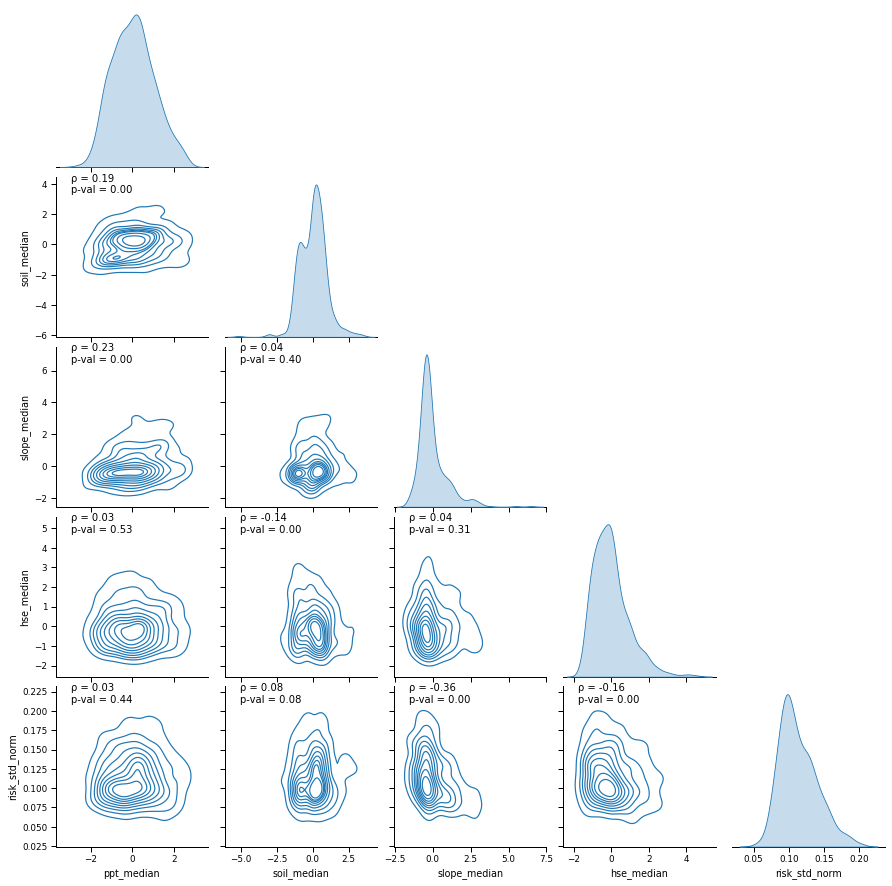

In [21]:
# Plot pairplot with norm_inputs
cluster_var = ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'risk_std_norm']
# cluster_gdf['risk_std_norm'] = (cluster_gdf['risk_std'] - cluster_gdf['risk_std'].mean()) / cluster_gdf['risk_std'].std()
high_unc = cluster_gdf[cluster_gdf['risk_std'] >= cluster_gdf['risk_std'].mean()]
g = sns.pairplot(high_unc[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_unc_indep.pdf', dpi=300, bbox_inches='tight')

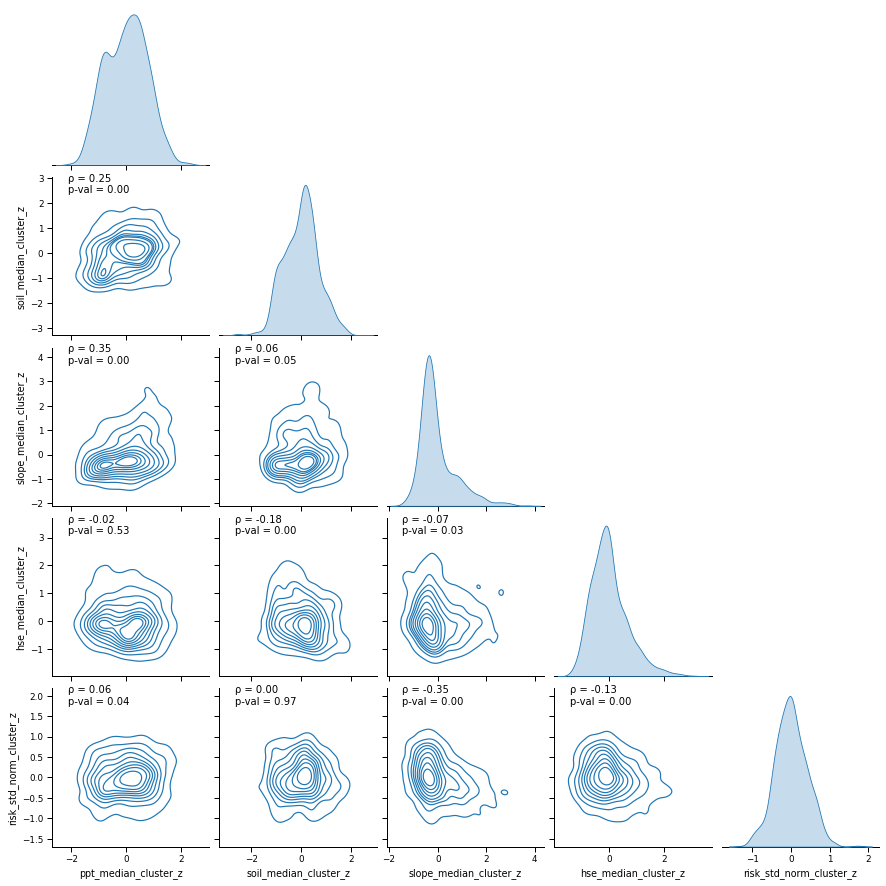

In [22]:
# Plot pairplot with cluster_z
cluster_var = ['ppt_median_cluster_z', 'soil_median_cluster_z', 'slope_median_cluster_z', 'hse_median_cluster_z', 'risk_std_norm_cluster_z']
# cluster_gdf['risk_std_norm'] = (cluster_gdf['risk_std'] - cluster_gdf['risk_std'].mean()) / cluster_gdf['risk_std'].std()
g = sns.pairplot(cluster_gdf[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_unc_cluster.pdf', dpi=300, bbox_inches='tight')

With risk estimate

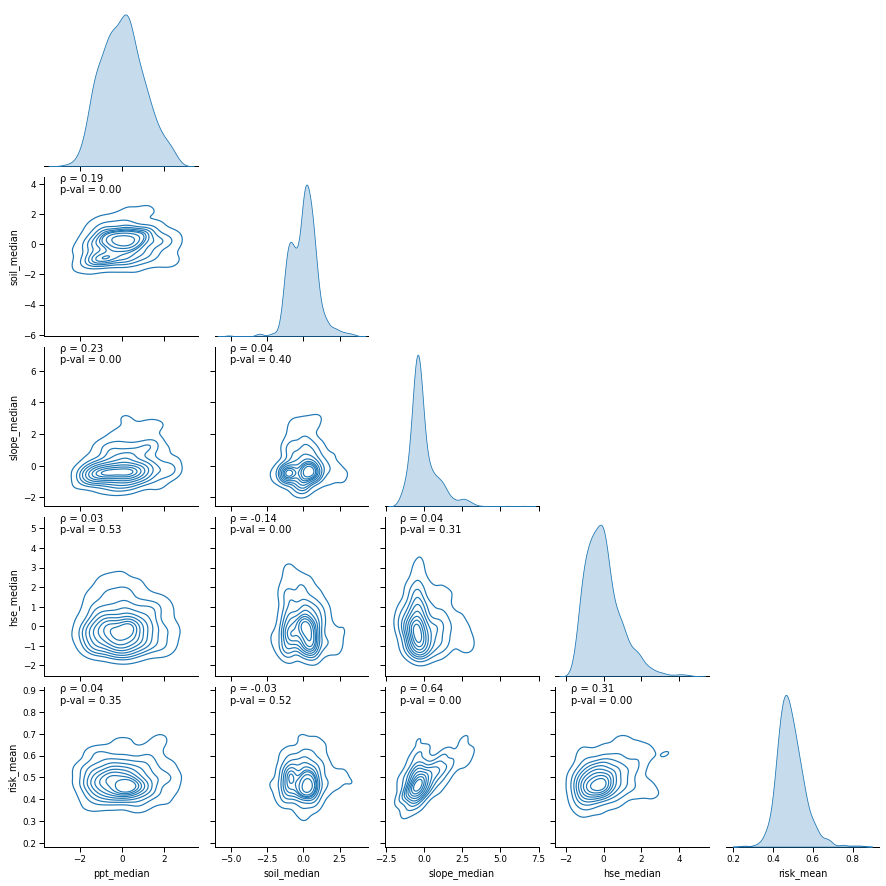

In [23]:
# Plot pairplot with norm_inputs
cluster_var = ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'risk_mean']
high_unc = cluster_gdf[cluster_gdf['risk_std'] >= cluster_gdf['risk_std'].mean()]
g = sns.pairplot(high_unc[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_risk_indep.pdf', dpi=300, bbox_inches='tight')

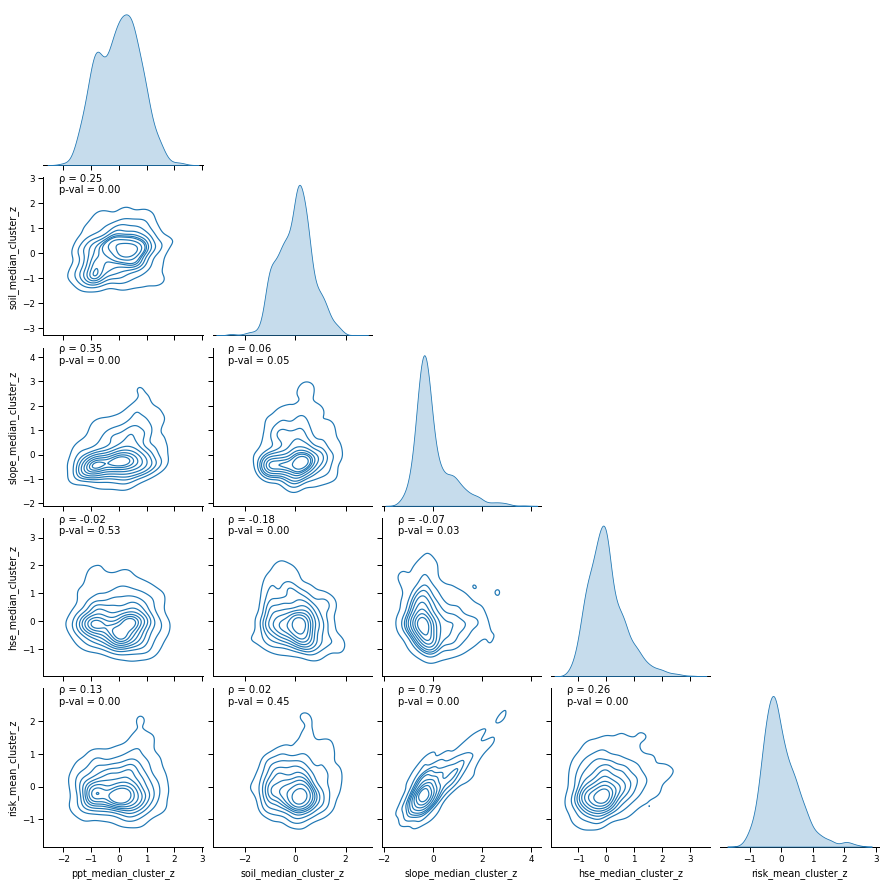

In [24]:
# Plot pairplot with cluster_z
cluster_var = ['ppt_median_cluster_z', 'soil_median_cluster_z', 'slope_median_cluster_z', 'hse_median_cluster_z', 'risk_mean_cluster_z']
# cluster_gdf['risk_std_norm'] = (cluster_gdf['risk_std'] - cluster_gdf['risk_std'].mean()) / cluster_gdf['risk_std'].std()
g = sns.pairplot(cluster_gdf[cluster_var], kind='kde', corner=True)
g.map_lower(corrfunc)
g.savefig('../docs/pairplot_risk_cluster.pdf', dpi=300, bbox_inches='tight')

# Archived

## Georgia

100%|██████████| 159/159 [00:01<00:00, 128.66it/s]


(-85.8434368, -80.60145719999998, 30.1257106, 35.2327994)

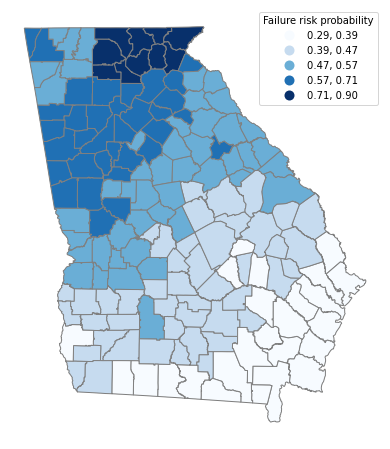

In [46]:
state_id = '13' # Georgia
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
# f.savefig('../docs/GA_risk_map.pdf', dpi=300)

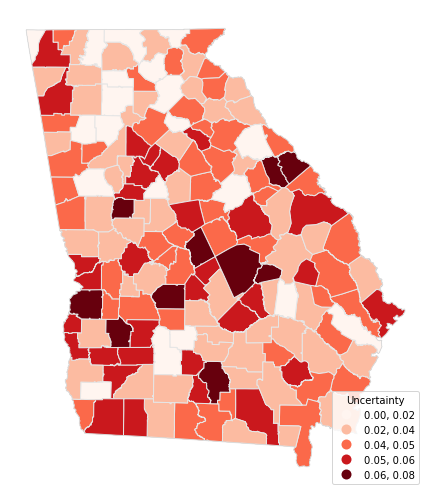

In [47]:
# Plot
f, ax = plt.subplots(figsize=(7,7))

# Plotting stateboundary
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')

gdf.plot(
    column='risk_std', 
    edgecolor='0.9',
    cmap='Reds', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Uncertainty', 'loc': 'lower right'})

bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.tight_layout()

<AxesSubplot:>

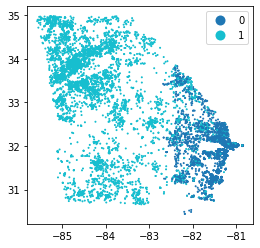

In [11]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))
gdf.sample(n=12000).plot(column='sewageSystem_enc', categorical=True, legend=True, markersize=1)

## Florida

100%|██████████| 67/67 [00:00<00:00, 199.64it/s]


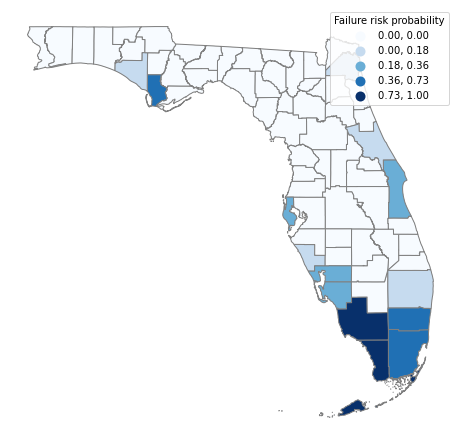

In [16]:
state_id = '12' # Florida
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/FL.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.savefig('../docs/FL_risk_map.pdf', dpi=300)

## Alabama

100%|██████████| 67/67 [00:00<00:00, 200.28it/s]


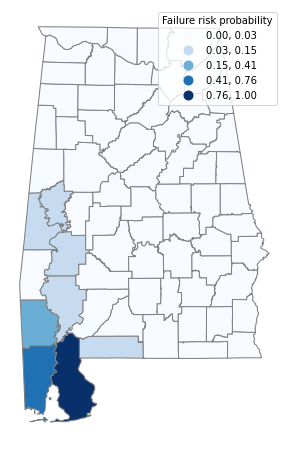

In [17]:
state_id = '01' # AL
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/AL.tif',
    'dem': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)
gdf = gdf.reset_index(drop=True)
gdf = gdf.fillna(0.)
for var in ['ppt_median', 'soil_median', 'dem_median', 'hse_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf = compute_risk_probability(gdf, learned_params)

# Plot
f, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column='risk_mean', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Failure risk probability'})


bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
bdry[bdry['STATEFP'] == state_id].dissolve(by='STATEFP').boundary.plot(
    edgecolor='grey',
    linewidth=0.1,
    ax=ax
)

ax.axis('off')
f.savefig('../docs/AL_risk_map.pdf', dpi=300)

# Inspect Inputs

In [7]:
state_id = '13' # Georgia
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'slope': '../../Data/dem/hyd_na_dem_15s.tif'
}

gdf = get_inference_data(indep_srcs, state_id=state_id)

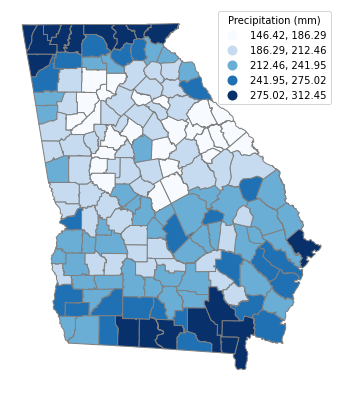

In [24]:
# Precipitation
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('ppt_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Precipitation (mm)'})

ax.axis('off');
f.savefig('../docs/GA_ppt.pdf', dpi=300, bbox_inches='tight')

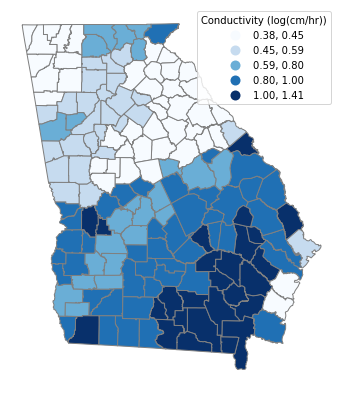

In [27]:
# Soil hydraulics
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('soil_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Conductivity (log(cm/hr))'})

ax.axis('off');
f.savefig('../docs/GA_soil.pdf', dpi=300, bbox_inches='tight')

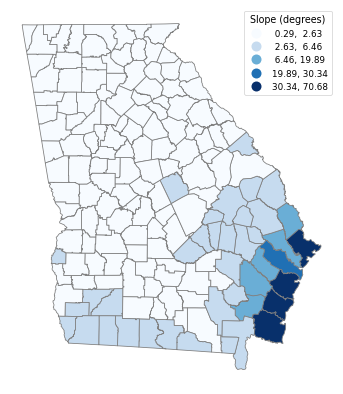

In [9]:
# DEM
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('slope_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Slope (degrees)'})

ax.axis('off');
f.savefig('../docs/GA_slope.pdf', dpi=300, bbox_inches='tight')

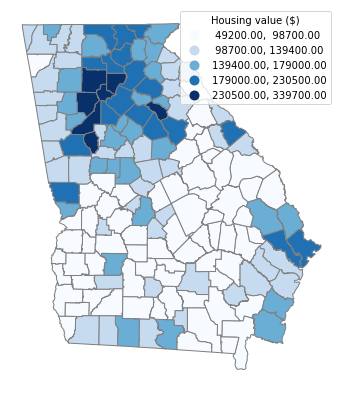

In [29]:
# Housing
f, ax = plt.subplots(figsize=(7,7))
gdf.plot('hse_median', 
    edgecolor='grey', 
    cmap='Blues', 
    scheme='natural_breaks', 
    ax=ax,
    legend=True, legend_kwds={'title': 'Housing value ($)'})

ax.axis('off');
f.savefig('../docs/GA_hse.pdf', dpi=300, bbox_inches='tight')